### Old Version

In [11]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

main_dir = r'D:\Projects\expense'

os.chdir(main_dir)

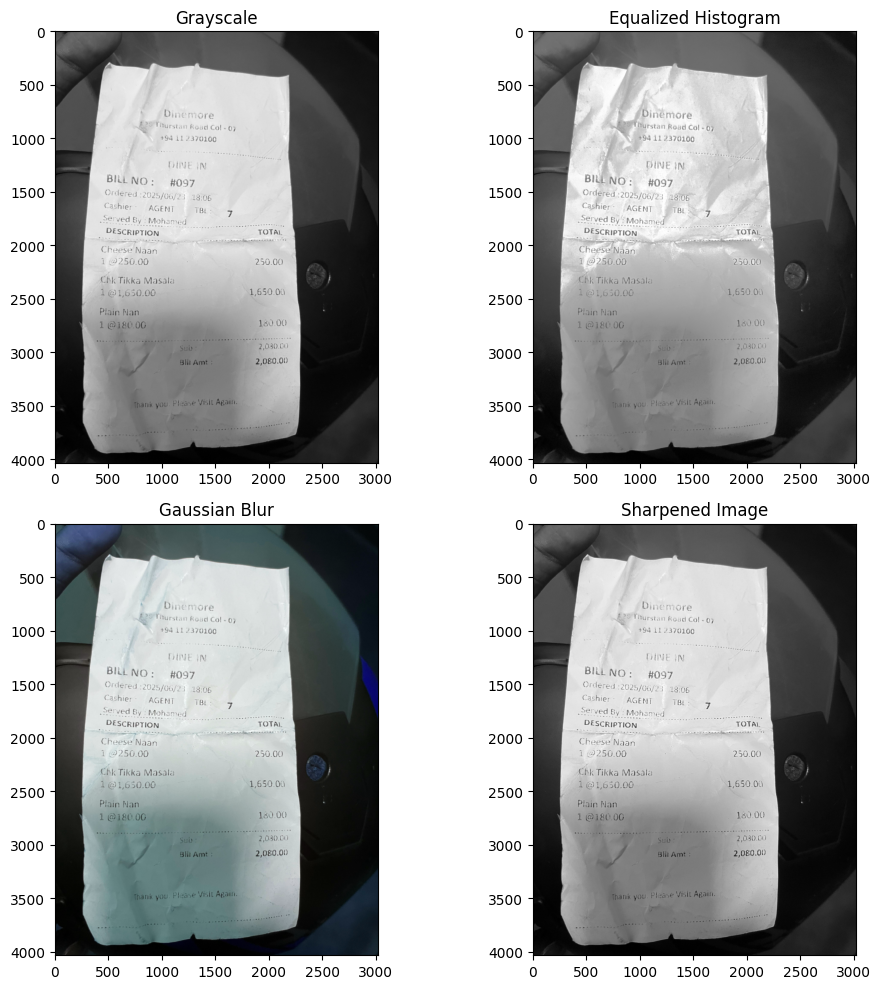

In [24]:
with open(r"D:\Projects\expense\data\2.jpg", "rb") as f:
    img_bytes = f.read()

arr = np.frombuffer(img_bytes, dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

cropped = crop_bill_region(img)       

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eq   = cv2.equalizeHist(gray)

blur = cv2.GaussianBlur(gray, (0,0), sigmaX=3)
sharpened = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)

eq2   = cv2.equalizeHist(sharpened)

# visualize the results
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
plt.subplot(222), plt.imshow(eq, cmap='gray'), plt.title('Equalized Histogram')
plt.subplot(223), plt.imshow(cropped, cmap='gray'), plt.title('Gaussian Blur')
plt.subplot(224), plt.imshow(sharpened, cmap='gray'), plt.title('Sharpened Image')
plt.tight_layout()

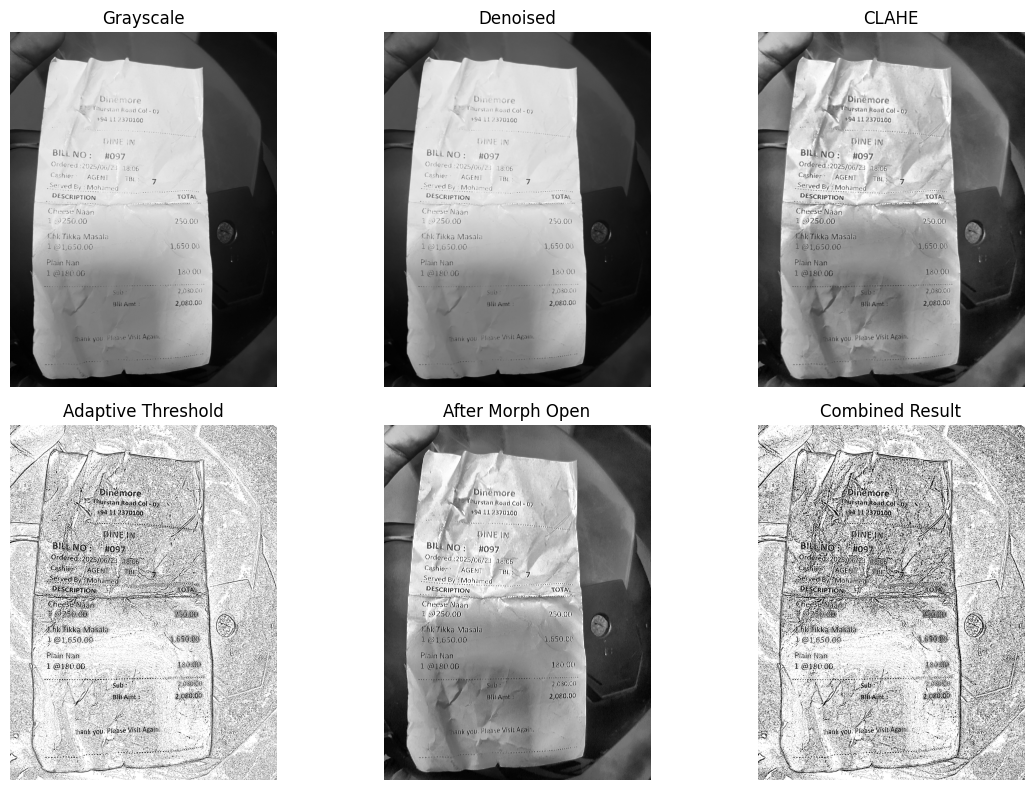

In [117]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 1. Load & decode
with open(r"D:\Projects\expense\data\2.jpg", "rb") as f:
    arr = np.frombuffer(f.read(), np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

# 2. Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray, None, h=11, templateWindowSize=31, searchWindowSize=9)
equalized = cv2.equalizeHist(denoised)

# 3. CLAHE (tileGridSize can be tuned)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl1 = clahe.apply(equalized)

resized = cv2.resize(cl1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# 4. Adaptive threshold (blockSize & C will need tuning)
th = cv2.adaptiveThreshold(
    cl1, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    blockSize=15, C=2
)

# 5. Morphological opening to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opened = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)

# 6. Optionally, top-hat to boost text strokes
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

# 7. Combine to get final mask (you can experiment weighting)
final = cv2.bitwise_or(opened, tophat)

# Visualize
plt.figure(figsize=(12,8))
for i,(img_,title) in enumerate([
    (gray,      "Grayscale"),
    (denoised,  "Denoised"),
    (cl1,       "CLAHE"),
    (th,        "Adaptive Threshold"),
    (resized,    "After Morph Open"),
    (final,     "Combined Result")
]):
    plt.subplot(2,3,i+1)
    plt.imshow(img_, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility to show images side by side
def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    plt.figure(figsize=(16, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


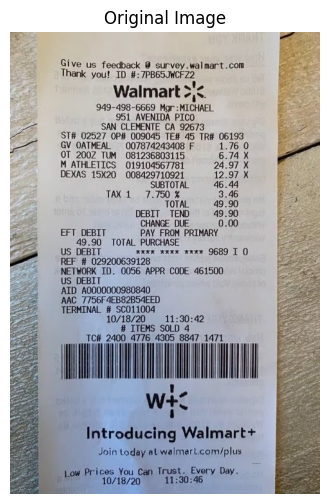

In [129]:
# Load the image
image = cv2.imread(r"D:\Projects\expense\data\images\2.jpg")  # Replace with your image path
original = image.copy()

# Convert BGR (OpenCV default) to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

show_images([image_rgb], ["Original Image"], cmap=None)


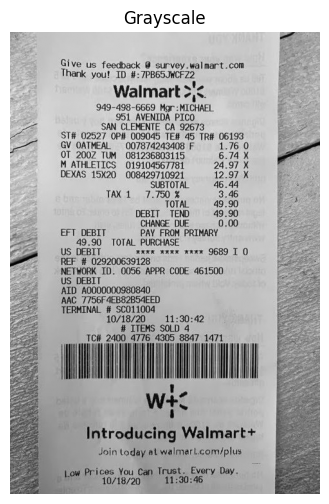

In [130]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_images([gray], ["Grayscale"])


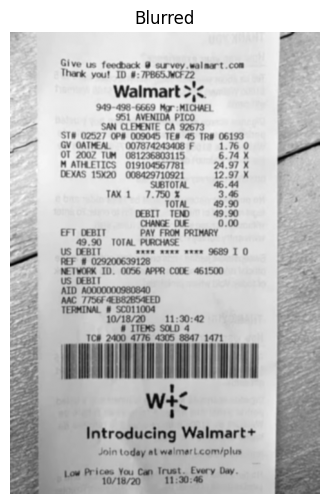

In [131]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
show_images([blurred], ["Blurred"])

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)

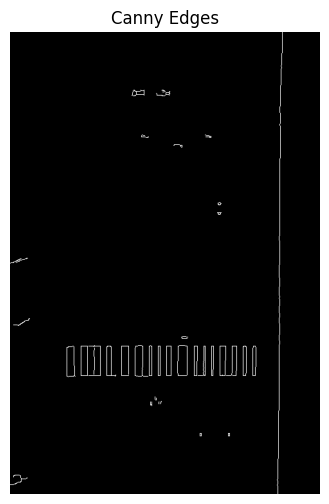

In [136]:
edges = cv2.Canny(dilated, threshold1=50, threshold2=150)
show_images([edges], ["Canny Edges"])


In [137]:
from imutils.perspective import four_point_transform
import imutils

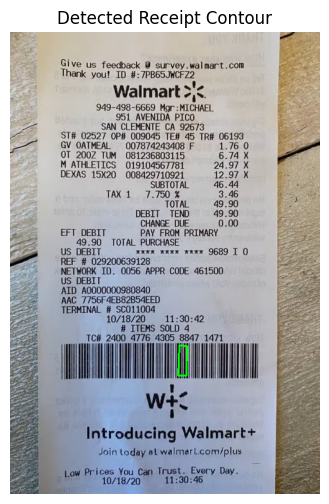

In [138]:
contours = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(contours)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# initialize a contour that corresponds to the receipt outline
receiptCnt = None
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we can
    # assume we have found the outline of the receipt
    if len(approx) == 4:
        receiptCnt = approx
        break
    
# visualize the contour
if receiptCnt is not None:
    cv2.drawContours(image_rgb, [receiptCnt], -1, (0, 255, 0), 2)
    show_images([image_rgb], ["Detected Receipt Contour"])

Found target contour with 4 vertices.


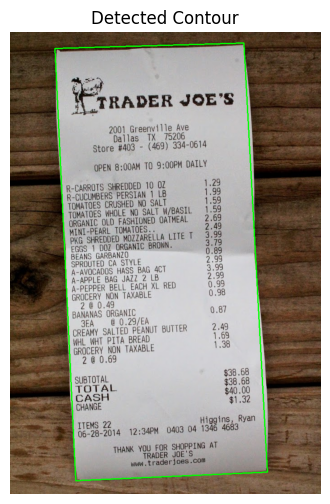

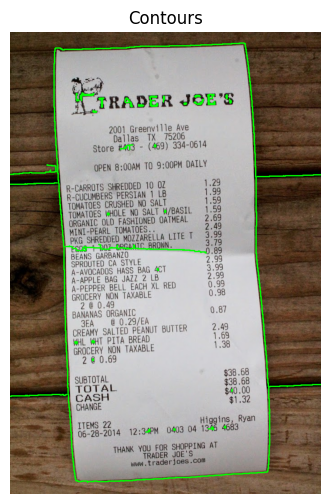

In [128]:
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for c in contours:
    p = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.1 * p, True)
    if len(approx) == 4:
        target_contour = approx
        print("Found target contour with 4 vertices.")
        break

contour_img = original.copy()

# Draw the detected contour on the original image
cv2.drawContours(contour_img, [target_contour], -1, (0, 255, 0), 2)
show_images([cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)], ["Detected Contour"])

contour_img = original.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
show_images([cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)], ["Contours"])

## New Version

In [8]:
from skimage import io, color
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt
 
img = io.imread(r"D:\Projects\expense\data\images\1.jpg")
gray = color.rgb2gray(img)
frequencies = dct(dct(gray, axis=0), axis=1)
frequencies[:2,:2] = 0
gray = idct(idct(frequencies, axis=1), axis=0)
gray = (gray - gray.min()) / (gray.max() - gray.min()) # renormalize to range [0:1]

In [9]:
from skimage import filters, morphology, measure
from scipy.ndimage import binary_fill_holes
import numpy as np
 
mask = filters.gaussian(gray, 2) > 0.5
mask = morphology.binary_closing(mask, footprint=morphology.disk(2))
mask = binary_fill_holes(mask, structure=morphology.disk(3, bool))
mask = measure.label(mask)
mask = (mask == 1 + np.argmax([r.filled_area for r in measure.regionprops(mask)]))

(-0.5, 687.5, 1023.5, -0.5)

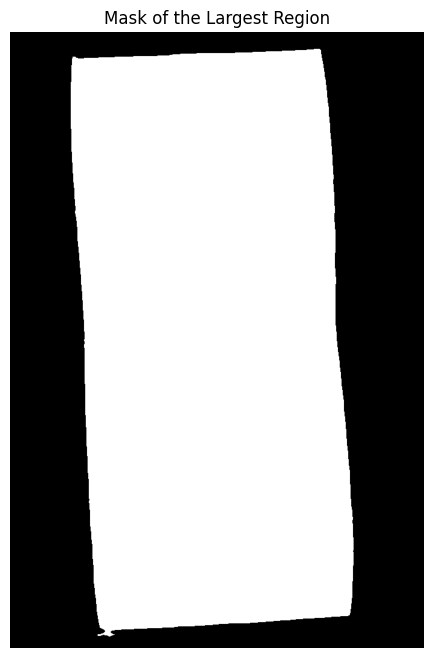

In [10]:
# visualize the mask
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('Mask of the Largest Region')
plt.axis('off')

In [13]:
def order_points(pts):
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect = np.zeros((4, 2), dtype="float32")
    rect[0] = pts[np.argmin(s)]       # top-left smallest (x+y)
    rect[2] = pts[np.argmax(s)]       # bottom-right largest (x+y)
    rect[1] = pts[np.argmin(diff)]    # top-right smallest (x-y)
    rect[3] = pts[np.argmax(diff)]    # bottom-left largest (x-y)
    return rect

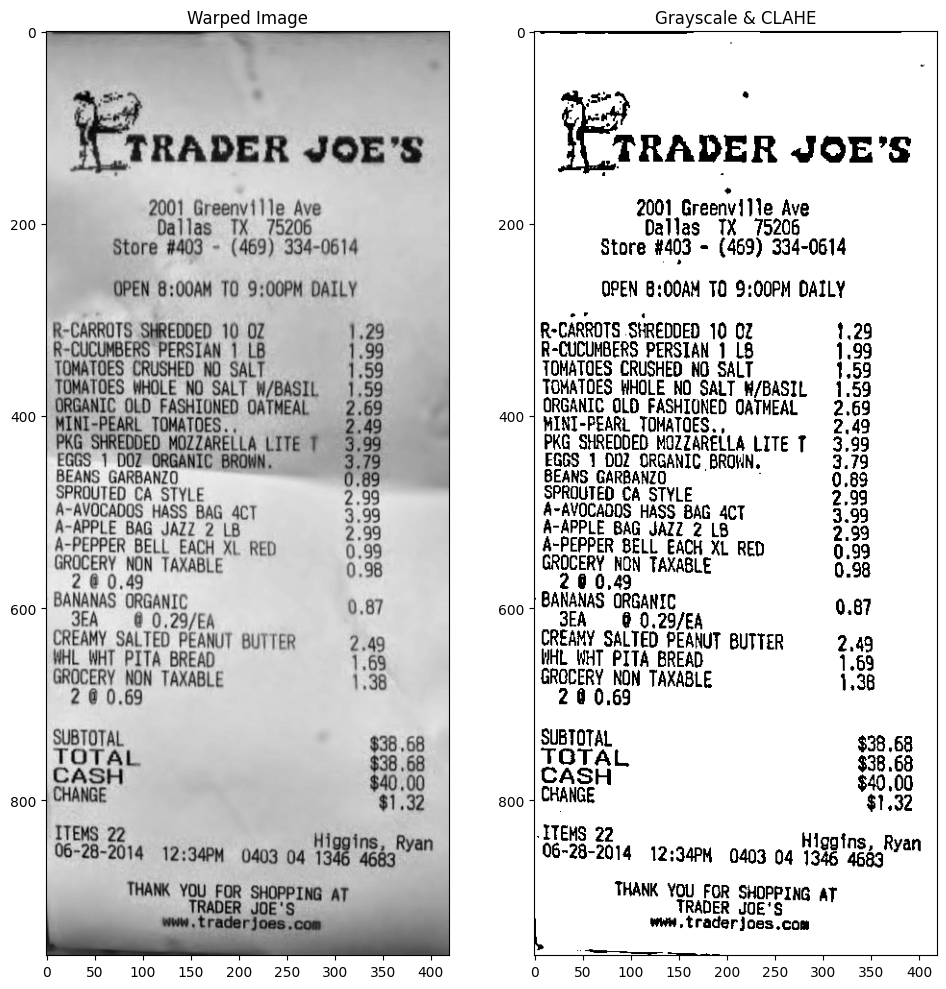

In [18]:
import cv2

mask_uint8 = (mask * 255).astype(np.uint8)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

if len(approx) == 4:
    corners = approx.reshape(4, 2).astype(np.float32)
else:
    print("Irregular contour skipping warp.")
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    corners = box.astype(np.float32)


ordered_pts = order_points(corners)

(tl, tr, br, bl) = ordered_pts
widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))

heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

if maxWidth < 10 or maxHeight < 10:
    print("Skipping warping: dimensions too small")
    warped = (img * 255).astype(np.uint8)
else:
    # desired destination points for the warped image
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(ordered_pts, dst)
    # warped = cv2.warpPerspective((img * 255).astype(np.uint8), M, (maxWidth, maxHeight))
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

gray_col = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
gray_col = cv2.fastNlMeansDenoising(gray_col, None, h=11, templateWindowSize=31, searchWindowSize=9)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_col = clahe.apply(gray_col) 

bw = cv2.adaptiveThreshold(gray_col, 255,
                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                        cv2.THRESH_BINARY, 25, 15)

bw_rgb = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB) 

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(gray_col, cv2.COLOR_BGR2RGB)), plt.title('Warped Image')
plt.subplot(122), plt.imshow(bw_rgb, cmap='gray'), plt.title('Grayscale & CLAHE')
plt.tight_layout()